# Second Checkpoint
### Predicting Pneumonia from X-Ray image

Jimena Salinas Valdespino, Santiago Segovia Baquero, Stephania Tello Zamudio, Ivanna Rodríguez Lobo

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image

from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

## Creating a Pytorch Dataset


In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir_path, resize=False, transform=None):
        """
        Inputs:
            - csv_file (str): file path to the csv file
            - img_dir_path: directory path to the images
            - transform: Compose (a PyTorch Class) that strings together several
              transform functions (e.g. data augmentation steps)
        """
        self.img_labels = pd.read_csv(csv_file, skiprows=1, header=None)
        self.img_dir = img_dir_path
        self.transform = transform
        self.resize = resize
        self.dimensions = self.get_dimensions()

    def __len__(self):
        """
        Returns: (int) length of your dataset
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """
        img_path =  os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        
        # read the image
        image = read_image(img_path)

        # get the label
        label = self.img_labels.iloc[idx, 1]

        # apply transformations to image
        if self.transform:
            image = self.transform(image)
            
        # resize
        if self.resize:
            image = self.resize_image(image)
        
        if image.shape[0] > 1: # if it has more than one channels
            g = T.Grayscale(1)
            image = g(image)

        return image, label
    
    def get_dimensions(self):
        """
        This method creates a dictionary with the unique combinations of heightxwidth
        for each image in the dataset.

        returns a dictionary with dimensions as keys and the number of images
            with that dimension as values
        """
        dimensions = {}
        for index in range(len(self.img_labels)):
            image = self[index][0]
            if self.resize:
                image = self.resize_image(image)
            _, height, width = image.shape
            dimensions[(height,width)] = dimensions.get((height,width),0) + 1

        return dimensions
    
    def resize_image(self,image):
        """
        If the resize parameter==True, then all the images are
        converted to a 150x150 size.

        returns the resized image
        """
        transform = T.Resize((150,150))
        
        return transform(image)

Once we implemented the Dataset class, we create one object per Dataset:

There are 16 unique height x width combinations in our validation data set.

Given that there are different sizes, and some very large images, we want to standarize the size of all images. We do this by passing a `resize` boolean parameter to our `CustomImageDataset` class.

## Image Augmentation

In order to avoid overfitting, we need to do image augmentation for our training
dataset. We do this below. We decided to augment the images following some 
examples of people who worked with this dataset in Kaggle.

The transformations we used are the following: rotate the image by 30 degrees, zoom into the image by 20%, flip the image horizontally, increase the image's sharpness, and change the color depth of the image.

In [3]:
train_transform = T.Compose([
    T.RandomRotation(30),
    T.RandomResizedCrop(size=(150, 150), scale=(0.8, 1.2)),
    T.RandomHorizontalFlip(),
    T.RandomAdjustSharpness(sharpness_factor=2),
    T.RandomPosterize(bits=4),
])

We then apply the above transformations to our datasets below.

In [4]:
# Apply the transforms to the training and validation dataset
train_data = CustomImageDataset(csv_file = '../data/data_train.csv',
                                img_dir_path = '../data',
                                resize=True,
                                transform=train_transform)

In [5]:
val_data = CustomImageDataset(csv_file = '../data/data_val.csv',
                              img_dir_path = '../data',
                                resize=True,
                                transform=train_transform)

In [6]:
test_data = CustomImageDataset(csv_file = '../data/data_test.csv',
                               img_dir_path = '../data',
                                resize=True,
                                transform=train_transform)

In [8]:
test_data[0]

(tensor([[[ 68,  69,  71,  ...,   0,   0,   0],
          [114, 131, 138,  ...,   0,   0,   0],
          [120, 114, 132,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ..., 175, 176, 207],
          [  0,   0,   0,  ..., 172, 192, 203],
          [  0,   0,   0,  ..., 184, 211, 200]]], dtype=torch.uint8),
 0)

In [12]:
all_labels=[]
all_inputs=[]
for i, data in enumerate(train_data):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    all_labels.append(labels)
    all_inputs.append(inputs)
    

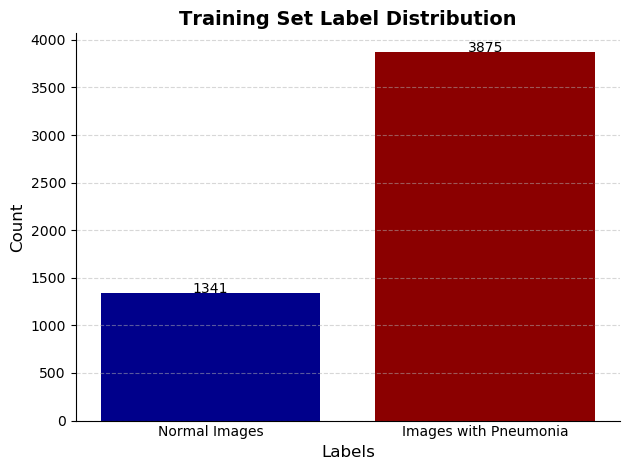

In [20]:
import matplotlib.pyplot as plt

# Count the occurrences of 0 and 1 in the list
normal_count = all_labels.count(0)
pneumonia_count = all_labels.count(1)

# Plotting the bar graph
labels = ['Normal Images', 'Images with Pneumonia']
counts = [normal_count, pneumonia_count]

# Define colors for the bars
colors = ['darkblue', 'darkred']

fig, ax = plt.subplots()
ax.bar(labels, counts, color=colors)

# Set additional styling options
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', length=0)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels above each bar
for i, count in enumerate(counts):
    ax.text(i, count + 0.2, str(count), ha='center')

plt.title('Training Set Label Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()

# Display the bar graph
plt.show()




## Creating our DataLoader

Below, we create our DataLoader. The purpose of doing this is to load our data in
batches to fit and test our model.

In [14]:
train_dataloader = DataLoader(train_data, 
                              batch_size=4, 
                              shuffle=True)

val_dataloader = DataLoader(val_data, 
                            batch_size=4, 
                            shuffle=True)

test_dataloader = DataLoader(test_data, 
                             batch_size=4, 
                             shuffle=True)

# Model

In [21]:
# class CustomNeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
      
#       # inspire by Turing award winning LeCun, Bengio and Hinton's paper from 1998
#       # https://ieeexplore.ieee.org/document/726791 (cited more than 25,000 times!!!!!!!!!)
#       # code from https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/ 
      
#         # self.LeNet = nn.Sequential(     
#         # convolutional layers
        
#         self.Layer1 = nn.Sequential(                                            # FIRST LAYER: (INPUT LAYER)
#             nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),    # CONVOLUTION 
#             nn.BatchNorm2d(6),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))             # POOLING
#         self.Layer2 = nn.Sequential(                                            # SECOND LAYER: HIDDEN LAYER 1
#             nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),   # CONVOLUTION 
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))             # POOLING
#           # fully connected layers
#         self.F = nn.Flatten()
        
#         self.LeNet = nn.Sequential(
#             nn.Sequential(                                            
#                 nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),    
#                 nn.BatchNorm2d(6),
#                 nn.ReLU(),
#                 nn.MaxPool2d(kernel_size = 2, stride = 2)),
#             nn.Sequential(                                            
#             nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0), 
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2)),
#             nn.Flatten()
#         )
      

#       # Calculate the input size for the linear layer
#         output_shape = self._get_conv_output_shape()
#         input_size = output_shape[0] * output_shape[1]

#       #self.classifier = nn.Sequential(
#         self.lin1 = nn.Linear(input_size, 64)
#         self.relu1 = nn.ReLU()       
#         self.lin2 = nn.Linear(64, 64)
#         self.relu2 = nn.ReLU()              
#         self.output = nn.Linear(64,2) 
                                                 
    
#     def _get_conv_output_shape(self):
#       # Create a dummy tensor and pass it through the convolutional layers
#         x = torch.zeros((1, 1, 150, 150))
#         conv_output = self.LeNet(x)
#         return conv_output.shape

#     def forward(self, x):
#         out = self.Layer1(x)
#         out = self.Layer2(out)
#         out = self.F(out)
#         out = self.lin1(out)
#         out = self.relu1(out)
#         out = self.lin2(out)
#         out = self.relu2(out)
#         out = self.output(out)
           
#         return out

import torch.nn as nn

class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2 )
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout(p=0.1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.dropout2 = nn.Dropout(p=0.2)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.dropout3 = nn.Dropout(p=0.2)
        self.batch_norm5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 10 * 10, 128)
        self.dropout4 = nn.Dropout(p=0.2)
        self.relu6 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.dropout1(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.dropout2(x)
        x = self.batch_norm4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.dropout3(x)
        x = self.batch_norm5(x)
        x = self.relu5(x)
        x = self.pool5(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout4(x)
        x = self.relu6(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


# Model's performance

In [22]:
model = CustomNeuralNetwork()

To assess the prediction capacity of our model we compare the model's loss an classification power. The first one is defined as the accuracy of the model in terms of the predicted probabilities, while the second refers to how good the model classifies the actual labels (*e.g.*, normal lungs or lungs with pneumonia).

The loss functions that we will use are:

1. Binary cross-entropy
2. Cross-entropy

On the other hand, the accuracy measures we'll use are:

1. Accuracy
2. F1

To assess the prediction capacity of our model we compare the model's loss an classification power. The first one is defined as the accuracy of the model in terms of the predicted probabilities, while the second refers to how good the model classifies the actual labels (*e.g.*, normal lungs or lungs with pneumonia).

Given that we are interested in classifying only two classes, the loss function that we'll use is the **binary cross-entropy**, which is defined as:

$$Loss = - \frac{1}{N} \sum_{i = 1}^{N} y_i \cdot log(\hat y_i) + (1 - y_i)\cdot log(1 - \hat y_i)$$

where $y_i$ is the label for the $i$-th observation, and $\hat y_i$ is the prediction. Intuitively the loss penalizes incorrect predictions more severely, with the logarithmic term amplifying the error when the predicted probability deviates from the true label. The overall loss is computed by averaging this binary cross-entropy loss over the entire training set.

On the other hand, the accuracy measures we'll use are:

1. **Accuracy**: provides an estimate of how well the model predicts the correct class labels

2. **F1**: combines the precision and recall metrics into a single value, providing a balanced assessment of the model's performance. Is particularly important for our case given that we have an imbalance dataset that contains more pneumonia images vs. normal images.

Both accuracy measures are going to be calculated for the train, validation and test dataset to evaluate the model's performance and potential overfitting.

In [23]:
batch = next(iter(train_dataloader))

In [24]:
x, labels = batch
x.shape

torch.Size([4, 1, 150, 150])

In [25]:
# Define a loss function and optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [26]:
# Train and validate the network
EPOCHS = 5

train_losses = []
train_accuracies = []
train_f1 = []
val_losses = []
val_accuracies = []
val_f1 = []

for e in range(EPOCHS):  # loop over the dataset multiple times
    print('Analyzing epoch:', e + 1)
    # TRAIN
    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    running_loss_train = 0.0
    accuracies_train = []
    f1_scores_train = []
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            inputs = inputs.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # keep track of the loss
            running_loss_train += loss.item()
            
            # ALSO CALCULATE YOUR ACCURACY METRIC
            predicted = predicted.detach().numpy()
            labels = labels.detach().numpy()

            accuracy = metrics.accuracy_score(labels, predicted)
            accuracies_train.append(accuracy)

            f1score = metrics.f1_score(labels, predicted)
            f1_scores_train.append(f1score)

    #AVERAGE TRAINING LOSS  
    avg_train_loss = running_loss_train / (i + 1)     # i + 1 gives us the total number of batches in train dataloader
    train_losses.append(avg_train_loss)
    # CALCULATE AVERAGE ACCURACY METRIC
    avg_train_acc = sum(accuracies_train)/len(accuracies_train)
    train_accuracies.append(avg_train_acc)
    #CALCULATE AVERAGE F1 SCORE
    avg_train_f1 = sum(f1_scores_train)/len(f1_scores_train)
    train_f1.append(avg_train_f1) 

    #VALIDATE
    # in the validation part, we don't want to keep track of the gradients 
    model.eval()
    running_loss_val = 0.0
    accuracies_val = []
    f1_scores_val = []
    for i, data in enumerate(val_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.float()

        # val prediction
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        # keep track of the loss
        running_loss_val += loss.item()

        # ALSO CALCULATE YOUR ACCURACY METRIC
        predicted = predicted.detach().numpy()
        labels = labels.detach().numpy()

        accuracy = metrics.accuracy_score(labels, predicted)
        accuracies_val.append(accuracy)

        f1score = metrics.f1_score(labels, predicted)
        f1_scores_val.append(f1score)

    # AVERAGE VALIDATION LOSS
    avg_val_loss = running_loss_val / (i + 1)     # i + 1 gives us the total number of batches in train dataloader
    val_losses.append(avg_val_loss)
    # CALCULATE AVERAGE ACCURACY METRIC
    avg_val_acc = sum(accuracies_val)/len(accuracies_val)
    val_accuracies.append(avg_val_acc)     
    #CALCULATE AVERAGE F1 SCORE
    avg_val_f1 = sum(f1_scores_val)/len(f1_scores_val)
    val_f1.append(avg_val_f1) 

    

Analyzing epoch: 1


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x1024 and 25600x128)

In [44]:
# Testing the model
test_losses = []
test_accuracies = []
test_f1 = []

for e in range(EPOCHS):  # loop over the dataset multiple times
    print('Analyzing epoch:', e + 1)
    model.eval()
    running_loss_test = 0.0
    accuracies_test = []
    f1_scores_test = []
    for i, data in enumerate(test_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()

        # test prediction
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # ALSO CALCULATE YOUR ACCURACY METRIC
        predicted = predicted.detach().numpy()
        labels = labels.detach().numpy()

        accuracy = metrics.accuracy_score(labels, predicted)
        accuracies_test.append(accuracy)

        f1score = metrics.f1_score(labels, predicted)
        f1_scores_test.append(f1score)

    # AVERAGE VALIDATION LOSS
    avg_test_loss = running_loss_test / (i + 1)     # i + 1 gives us the total number of batches in train dataloader
    test_losses.append(avg_test_loss)
    # CALCULATE AVERAGE ACCURACY METRIC
    avg_test_acc = sum(accuracies_test)/len(accuracies_test)   
    test_accuracies.append(avg_test_acc)  
    #CALCULATE AVERAGE F1 SCORE
    avg_test_f1 = sum(f1_scores_test)/len(f1_scores_test)
    test_f1.append(avg_test_f1) 
    
    

Analyzing epoch: 1
Analyzing epoch: 2
Analyzing epoch: 3
Analyzing epoch: 4
Analyzing epoch: 5
Analyzing epoch: 6
Analyzing epoch: 7
Analyzing epoch: 8
Analyzing epoch: 9
Analyzing epoch: 10


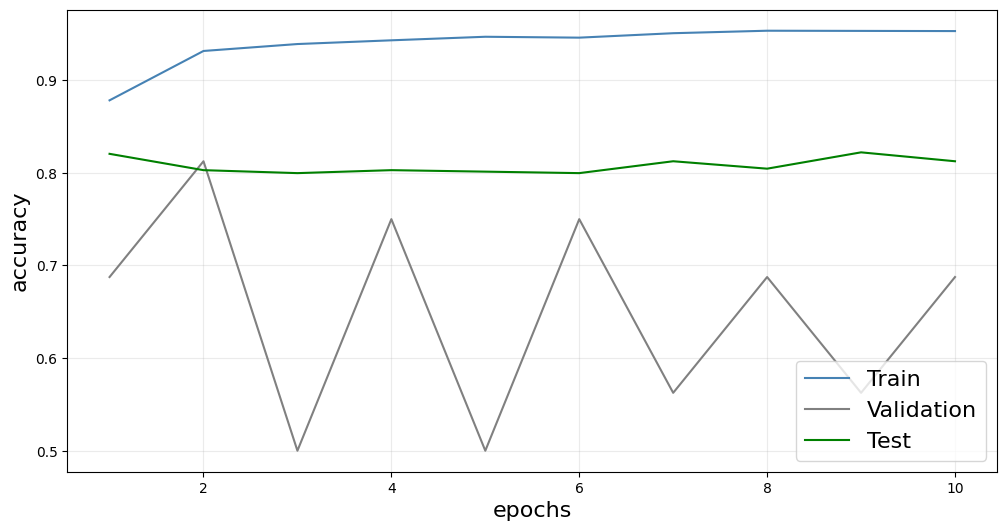

In [45]:
# Plotting the training, testing and validation accuracies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i + 1 for i in range(0, EPOCHS, 1)]
ax.plot(epochs_array, train_accuracies, color="steelblue", label='Train')
ax.plot(epochs_array, val_accuracies, color="grey", label='Validation')
ax.plot(epochs_array, test_accuracies, color="green", label='Test')
ax.grid(alpha=0.25)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.show()

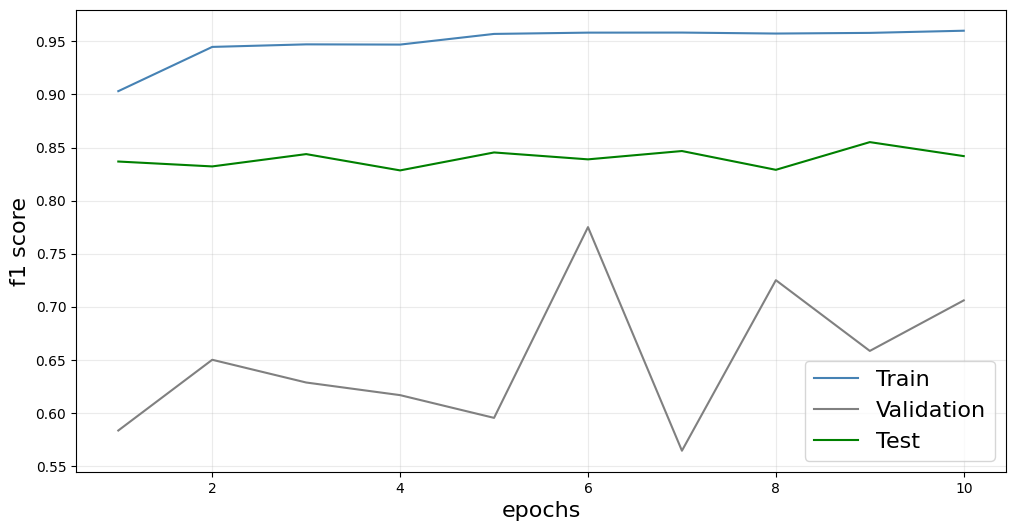

In [46]:
# Plotting the training, testing and validation F1 scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i + 1 for i in range(0, EPOCHS, 1)]
ax.plot(epochs_array, train_f1, color="steelblue", label='Train')
ax.plot(epochs_array, val_f1, color="grey", label='Validation')
ax.plot(epochs_array, test_f1, color="green", label='Test')
ax.grid(alpha=0.25)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("f1 score", fontsize=16)
plt.show()

From the graphs above, it seems like the trained convolutional neural network model performs well on the training data with a stable training accuracy of 0.95 after the first epoch. However, the testing accuracy remains around 0.8, which indicates that the model might be overfitting to the training data. This could be due to the unbalanced nature of the training dataset, with almost three times more images of pneumonia than normal. This suggests that the model might be biased towards predicting pneumonia more often.

The F1 score for training is around 0.95, which indicates that the model has a good balance between precision and recall for the training data. However, the F1 score for testing is 0.85, which suggests that the model's performance on the testing data is not as good as on the training data. This might be due to the unbalanced training dataset, which makes it difficult for the model to generalize well to new, unseen data.

In order to improve the model, we plan to run the model using a binary cross entropy loss function since it is specifically desgined for binary classification problems. We expect this could help the model's perfomance since this function penalizes more heavily for misclassifying instances from the minority class (i.e., normal in this case), which could help to address the imbalance in the training dataset. Additionally, we can try introducing a regularization term in order to prevent overfitting and improve the generalization ability of the model.